In [51]:
from pdfminer.high_level import extract_text
import os

In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Handhika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Handhika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopwords_id = set(stopwords.words('indonesian'))

def bersihkan_teks(teks):
    # 1. Hilangkan header/footer/nama pengadilan
    teks = re.sub(r'^(MAHKAMAH.*?PUTUSAN).*', '', teks, flags=re.IGNORECASE | re.DOTALL)
    
    # 2. Hilangkan karakter non-alfabet
    teks = re.sub(r'[^\w\s]', ' ', teks)

    # 3. Normalisasi: huruf kecil
    teks = teks.lower()

    # 4. Tokenisasi
    tokens = word_tokenize(teks)

    # 5. Hapus stopword
    tokens = [t for t in tokens if t not in stopwords_id and len(t) > 2]

    # 6. Gabung kembali jadi string
    return ' '.join(tokens)


In [54]:
import nltk
nltk.download('punkt')  # Only needed once
nltk.download('stopwords')  # Only needed once
from nltk.tokenize import word_tokenize

def bersihkan_teks(teks):
    tokens = word_tokenize(teks)  # Will now work
    # ... rest of your cleaning code ...

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Handhika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Handhika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
import os
import re
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Initialize Indonesian stopwords
stopwords_id = set(stopwords.words('indonesian'))

def bersihkan_teks(teks):
    """
    Clean and preprocess Indonesian text by:
    1. Removing special characters/numbers
    2. Converting to lowercase
    3. Tokenizing
    4. Removing stopwords
    5. Joining back into clean text
    """
    # 1. Remove special characters and numbers
    teks = re.sub(r'[^a-zA-Z\s]', '', teks)
    
    # 2. Convert to lowercase
    teks = teks.lower()
    
    # 3. Tokenize
    tokens = word_tokenize(teks)
    
    # 4. Remove stopwords and short words
    tokens = [t for t in tokens if t not in stopwords_id and len(t) > 2]
    
    # 5. Join back into clean text
    return ' '.join(tokens)

# Folder paths
folder_txt = "data/extracted_texts/"
folder_cleaned = "data/cleaned_txt/"
os.makedirs(folder_cleaned, exist_ok=True)

# Process all text files
for nama_file in tqdm(os.listdir(folder_txt)):
    if nama_file.endswith(".txt"):
        with open(os.path.join(folder_txt, nama_file), "r", encoding="utf-8") as f:
            teks_mentah = f.read()

        teks_bersih = bersihkan_teks(teks_mentah)

        with open(os.path.join(folder_cleaned, nama_file), "w", encoding="utf-8") as f:
            f.write(teks_bersih)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Handhika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Handhika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 33/33 [00:01<00:00, 25.74it/s]


In [56]:
import re

def ekstrak_metadata(teks):
    metadata = {}

    nomor = re.search(r"nomor\s*:?\s*([\w./-]+)", teks, re.IGNORECASE)
    tanggal = re.search(r"tanggal putusan\s*:?\s*([^\n]+)", teks, re.IGNORECASE)
    pasal = re.findall(r'pasal\s+\d+\s*(?:ayat\s+\(\d+\))?', teks, re.IGNORECASE)

    metadata["nomor_perkara"] = nomor.group(1) if nomor else None
    metadata["tanggal"] = tanggal.group(1) if tanggal else None
    metadata["pasal"] = pasal
    return metadata


In [57]:
case = {
    "nama_file": nama_file,
    "metadata": ekstrak_metadata(teks_bersih),
    "teks_bersih": teks_bersih
}


In [58]:
import json

semua_case = []
for file in os.listdir("data/cleaned_txt"):
    with open(os.path.join("data/cleaned_txt", file), "r", encoding="utf-8") as f:
        teks = f.read()
    case = {
        "nama_file": file,
        "metadata": ekstrak_metadata(teks),
        "teks_bersih": teks
    }
    semua_case.append(case)

with open("case_base.json", "w", encoding="utf-8") as f:
    json.dump(semua_case, f, ensure_ascii=False, indent=2)


Vector

In [59]:
import os
import pandas as pd

folder = "data/cleaned_txt"
dokumen = []

for nama_file in os.listdir(folder):
    if nama_file.endswith(".txt"):
        with open(os.path.join(folder, nama_file), "r", encoding="utf-8") as f:
            teks = f.read()
        dokumen.append({
            "nama_file": nama_file,
            "teks": teks
        })

df = pd.DataFrame(dokumen)


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # kamu bisa ubah jumlah fitur
X_tfidf = vectorizer.fit_transform(df['teks'])

print(X_tfidf.shape)  # jumlah dokumen x jumlah fitur


(33, 1000)


In [61]:
feature_names = vectorizer.get_feature_names_out()

for i, row in enumerate(X_tfidf.toarray()):
    top_idx = row.argsort()[-5:][::-1]  # 5 kata terpenting
    top_words = [feature_names[j] for j in top_idx]
    print(f"{df.iloc[i]['nama_file']} → Top words: {top_words}")


case (1).txt → Top words: ['lembar', 'agung', 'nomor', 'mahkamah', 'tanggal']
case (10).txt → Top words: ['agung', 'mahkamah', 'nomor', 'indonesia', 'republik']
case (11).txt → Top words: ['pendukungnya', 'astica', 'agung', 'mahkamah', 'nomor']
case (12).txt → Top words: ['agung', 'mahkamah', 'nomor', 'bpkb', 'vinoli']
case (13).txt → Top words: ['agung', 'mahkamah', 'indonesia', 'republik', 'informasi']
case (14).txt → Top words: ['monta', 'perkasa', 'agung', 'mahkamah', 'indonesia']
case (15).txt → Top words: ['piece', 'indonesia', 'master', 'agung', 'mahkamah']
case (16).txt → Top words: ['agung', 'mahkamah', 'penyiaran', 'indonesia', 'republik']
case (17).txt → Top words: ['mahkamah', 'agung', 'republik', 'indonesia', 'informasi']
case (18).txt → Top words: ['agung', 'mahkamah', 'indonesia', 'republik', 'samarinda']
case (19).txt → Top words: ['agung', 'mahkamah', 'indonesia', 'republik', 'medan']
case (2).txt → Top words: ['nestle', 'pajak', 'copy', 'indonesia', 'pertambahan']
cas

In [62]:
query = "terdakwa membawa sabu dan melanggar pasal 114 uu narkotika"
query_vec = vectorizer.transform([query])


In [63]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(query_vec, X_tfidf).flatten()
top_k = similarities.argsort()[-5:][::-1]

print("Top 5 kasus paling mirip:")
for idx in top_k:
    print(f"{df.iloc[idx]['nama_file']} (score: {similarities[idx]:.3f})")


Top 5 kasus paling mirip:
case (19).txt (score: 0.124)
case (16).txt (score: 0.117)
case (18).txt (score: 0.114)
case (30).txt (score: 0.109)
case (15).txt (score: 0.097)


In [64]:
import transformers

In [65]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")


In [66]:
def bert_embed(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # [1, seq_len, hidden_size]
    embeddings = last_hidden_state.mean(dim=1)     # [1, hidden_size]
    return embeddings.squeeze().numpy()


Case  Retrieval

In [93]:
import os
import numpy as np
from tqdm import tqdm

folder = "data/cleaned_txt"
vectors = []
filenames = []

for file in tqdm(os.listdir(folder)):
    if file.endswith(".txt"):
        with open(os.path.join(folder, file), "r", encoding="utf-8") as f:
            text = f.read()

        # Buat vektor IndoBERT
        try:
            vec = bert_embed(text)
            vectors.append(vec)
            filenames.append(file)
        except Exception as e:
            print(f"Gagal embed {file}: {e}")


100%|██████████| 33/33 [00:02<00:00, 12.23it/s]


In [94]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/processed/cases.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv("data/processed/train.csv", index=False)
test_df.to_csv("data/processed/test.csv", index=False)


In [91]:
def retrieve(query: str, vectors, filenames, k: int = 5):
    # 1) Preprocess query (opsional)
    # 2) Hitung vektor query
    query_vec = bert_embed(query)

    # 3) Hitung cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity([query_vec], vectors).flatten()

    # 4) Ambil top-k indeks
    top_k = similarities.argsort()[-k:][::-1]

    # 5) Kembalikan list case_id atau nama file
    return [filenames[i] for i in top_k]


In [95]:
print(len(vectors))   # Harusnya: 33
print(vectors[0].shape)  # Harusnya: (768,)

33
(384,)


In [89]:
vectors = []
filenames = []


In [72]:
print(filenames[:34])
# Output: ['putusan1.txt', 'putusan2.txt', 'putusan3.txt']


[]


In [73]:
for f in os.listdir("data/cleaned_txt"):
    with open(os.path.join("data/cleaned_txt", f), "r", encoding="utf-8") as file:
        teks = file.read().lower()
        if "faktur pajak" in teks and "pasal 39" in teks:
            print(f)


In [74]:
[
  {
    "query": "Terdakwa tidak menyampaikan SPT Tahunan selama 3 tahun berturut-turut dan menyebabkan kerugian pada pendapatan negara.",
    "ground_truth": ["putusan_01.txt"]
  },
  {
    "query": "Wajib Pajak didakwa memalsukan faktur pajak dan melanggar Pasal 39 ayat (1) huruf c UU KUP.",
    "ground_truth": ["putusan_04.txt"]
  },
  {
    "query": "Terdakwa menyampaikan SPT Masa PPN yang tidak benar sehingga merugikan negara.",
    "ground_truth": ["putusan_07.txt"]
  },
  {
    "query": "Tersangka menyuruh orang lain membuat faktur pajak fiktif untuk menghindari pembayaran PPN.",
    "ground_truth": ["putusan_12.txt"]
  },
  {
    "query": "Wajib pajak diduga dengan sengaja tidak menyetorkan pajak yang telah dipotong dari pihak lain.",
    "ground_truth": ["putusan_15.txt"]
  }
]


[{'query': 'Terdakwa tidak menyampaikan SPT Tahunan selama 3 tahun berturut-turut dan menyebabkan kerugian pada pendapatan negara.',
  'ground_truth': ['putusan_01.txt']},
 {'query': 'Wajib Pajak didakwa memalsukan faktur pajak dan melanggar Pasal 39 ayat (1) huruf c UU KUP.',
  'ground_truth': ['putusan_04.txt']},
 {'query': 'Terdakwa menyampaikan SPT Masa PPN yang tidak benar sehingga merugikan negara.',
  'ground_truth': ['putusan_07.txt']},
 {'query': 'Tersangka menyuruh orang lain membuat faktur pajak fiktif untuk menghindari pembayaran PPN.',
  'ground_truth': ['putusan_12.txt']},
 {'query': 'Wajib pajak diduga dengan sengaja tidak menyetorkan pajak yang telah dipotong dari pihak lain.',
  'ground_truth': ['putusan_15.txt']}]

In [79]:
documents = [
    "pelanggaran pajak tahunan oleh wajib pajak",
    "ketentuan pengampunan pajak di Indonesia",
    "sanksi untuk keterlambatan pembayaran PPh",
    "prosedur banding pajak penghasilan"
]
filenames = ["case(1).txt", "case(2).txt", "case(3).txt", "case(4).txt"]

In [98]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Initialize model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

def bert_embed(text):
    """Returns 1D numpy array"""
    return model.encode(text, convert_to_numpy=True).flatten()

def retrieve_similar_cases(query, vectors, filenames, k=5):
    try:
        # 1. Validate inputs
        if len(vectors) == 0 or len(filenames) == 0:
            raise ValueError("Empty vectors or filenames list")
        if len(vectors) != len(filenames):
            raise ValueError("Vectors and filenames length mismatch")
            
        # 2. Get query embedding
        query_vec = bert_embed(query).reshape(1, -1)
        vectors = np.array(vectors)
        
        # 3. Calculate similarities
        similarities = cosine_similarity(query_vec, vectors)[0]
        
        # 4. Get top-k results with bounds checking
        valid_k = min(k, len(filenames))
        top_k = similarities.argsort()[-valid_k:][::-1]
        
        return [(filenames[i], similarities[i]) for i in top_k if i < len(filenames)]
    
    except Exception as e:
        print(f"Error in retrieval: {str(e)}")
        return []

documents = [
    # case (1).txt
    "Terdakwa Fadlan Djakfar didakwa sengaja membantu tindak pidana perpajakan berlanjut, yaitu menerbitkan faktur pajak berbarcode identitas Agung Kota Mandiri yang terbukti tidak berdasarkan transaksi sebenarnya, menyebabkan kerugian negara sebesar 96 juta rupiah lebih. Putusan kasasi memperbaiki denda.",
    
    # case (2).txt
    "Terdakwa Ida Laila binti Musripin, ketua kelompok usaha Rendingan, didakwa sengaja tidak menyetorkan Pajak Pertambahan Nilai (PPN) yang dipungut dari transaksi penjualan biji kopi. Kerugian pendapatan negara dihitung 10 miliar rupiah lebih. Terdakwa menjual aset tanah untuk menutupi denda.",
    
    # case (3).txt
    "Terdakwa Ir. Roni Wijaya, Direktur Keuangan PT Dutasari Citralaras, didakwa tindak pidana perpajakan dan tindak pidana pencucian uang. Terdakwa menginstruksikan pembelian dan penggunaan faktur pajak fiktif serta menyamarkan hasil tindak pidana untuk membeli aset properti. Putusan peninjauan kembali membatalkan putusan sebelumnya dan memerintahkan pengembalian kelebihan bayar denda.",
    
    # case (4).txt
    "Terdakwa Dian Ekawati, Komisaris PT Cahayasurya Timur, didakwa sengaja tidak menyetorkan SPT Tahunan dan memalsukan faktur pajak. Terdakwa terbukti melakukan pengkreditan faktur pajak fiktif tanpa transaksi sebenarnya, menyebabkan kerugian negara. Putusan kasasi menguatkan putusan pengadilan negeri dengan pidana penjara dan denda.",
    
    # case (5).txt
    "Terpidana Albert Lie, Direktur Karyaputra Lokatirta, didakwa pidana perpajakan karena menggunakan faktur pajak fiktif berdasarkan transaksi tidak sebenarnya (TBTS) yang dibeli dengan tujuan memperkecil pembayaran pajak. Putusan peninjauan kembali menolak permohonan terpidana dan menguatkan putusan sebelumnya.",
    
    # case (6).txt
    "Terdakwa Suminto bin Priyo Utomo didakwa menyediakan dan menjual barang kena cukai (rokok) jenis Sigaret Putih Mesin (SPM) merek Luffman American Blend tanpa dilekati pita cukai. Perbuatan ini menimbulkan kerugian negara. Putusan kasasi menolak permohonan penuntut dan menguatkan pidana yang dijatuhkan.",
    
    # case (7).txt
    "Terdakwa Mohamad Aly Shobat, Direktur Cahaya Firdaus, didakwa sengaja tidak menyetorkan Pajak Pertambahan Nilai (PPN) yang telah dipungut dari perusahaan seperti Pertamina. Putusan peninjauan kembali mengabulkan permohonan terpidana, membatalkan putusan sebelumnya, dan memerintahkan pengembalian kelebihan bayar denda karena kerugian negara telah dipulihkan.",
    
    # case (8).txt
    "Terdakwa Tri Anis Noorbaiti, mantan General Manager Finance Accounting Shields Indonesia, didakwa tidak melaporkan SPT lengkap dan tidak menyetorkan pajak yang dipotong/dipungut (PPN dan PPh Pasal 23 rekanan). Putusan peninjauan kembali menguatkan bahwa terpidana terbukti bersalah.",
    
    # case (9).txt
    "Terdakwa Ihmar, Direktur Andoyo Tofan Nugraha Abadi, didakwa sengaja menerbitkan faktur pajak berdasarkan transaksi tidak sebenarnya (TBTS) dan mengkreditkan SPT PPN fiktif, yang menyebabkan kerugian negara. Putusan kasasi menolak permohonan terpidana dan menguatkan putusan sebelumnya.",
]

filenames = [
    "case (1).txt",
    "case (2).txt",
    "case (3).txt",
    "case (4).txt",
    "case (5).txt",
    "case (6).txt",
    "case (7).txt",
    "case (8).txt",
    "case (9).txt"
]
# Precompute vectors
vectors = [bert_embed(doc) for doc in documents]

# Test query
query = "Pelanggaran SPT Tahunan"
results = retrieve_similar_cases(query, vectors, filenames)

if not results:
    print("⚠️ No results returned. Check your inputs.")
else:
    for filename, score in results:
        print(f"{filename}: {score:.4f}")

case (8).txt: 0.3913
case (4).txt: 0.3798
case (3).txt: 0.2745
case (9).txt: 0.2676
case (7).txt: 0.1847


In [84]:
top_k = [3, 7, 10, 4, 19]  # indeks file teratas hasil similarity
filenames = [...]           # nama-nama file .txt


In [85]:
def ambil_teks_file(nama_file, folder="data/cleaned_txt"):
    with open(os.path.join(folder, nama_file), "r", encoding="utf-8") as f:
        return f.read()


In [99]:
print("Shape vectors:", len(vectors))
print("Shape filenames:", len(filenames))

Shape vectors: 9
Shape filenames: 9


In [100]:
from sklearn.model_selection import train_test_split

# Contoh split vektor dan nama file
X_train, X_test, filenames_train, filenames_test = train_test_split(vectors, filenames, test_size=0.2, random_state=42)


In [101]:
import json
import os

# Buat folder eval jika belum ada
os.makedirs("data/eval", exist_ok=True)

# Isi queries dan ground_truth (silakan sesuaikan)
queries = [
  {
    "query": "Terdakwa tidak menyampaikan Surat Pemberitahuan (SPT) Tahunan Pajak Penghasilan secara sengaja, yang mengakibatkan kerugian pendapatan negara.",
    "ground_truth": ["case (24).txt"]
  },
  {
    "query": "Terdakwa mengkreditkan faktur pajak fiktif tanpa transaksi sebenarnya, melanggar UU Ketentuan Umum dan Tata Cara Perpajakan.",
    "ground_truth": ["case (30).txt"]
  },
  {
    "query": "Terdakwa menyampaikan faktur pajak tidak sah untuk mengurangi pajak yang terutang, menyebabkan kerugian negara.",
    "ground_truth": ["case (4).txt"]
  },
  {
    "query": "Terdakwa terbukti melakukan pelanggaran Pasal 39 UU KUP dan Pasal 3 UU TPPU karena menyembunyikan aset dari penghasilan tak sah.",
    "ground_truth": ["case (3).txt"]
  },
  {
    "query": "Terdakwa tidak menyetorkan PPN yang telah dipungut kepada negara, berdasarkan pasal 39 ayat 1 huruf i UU KUP.",
    "ground_truth": ["case (33).txt"]
  }
]


# Simpan ke JSON
with open("data/eval/queries.json", "w", encoding="utf-8") as f:
    json.dump(queries, f, indent=2, ensure_ascii=False)

print("✅ queries.json berhasil dibuat.")


✅ queries.json berhasil dibuat.


In [102]:
def evaluate_retrieval(eval_queries, vectors, filenames, k=5):
    from sklearn.metrics import precision_score

    total = 0
    matched = 0
    for q in eval_queries:
        pred = retrieve(q["query"], vectors, filenames, k=k)
        if any(p in q["ground_truth"] for p in pred):
            matched += 1
        total += 1
    print(f"Accuracy top-{k}: {matched}/{total} = {matched/total:.2f}")


In [103]:
import json

with open("data/eval/queries.json", encoding="utf-8") as f:
    queries = json.load(f)

evaluate_retrieval(queries, vectors, filenames, k=5)


Accuracy top-5: 2/5 = 0.40


In [104]:
import os

folder = "data/cleaned_txt"
docs = []
filenames = []

for fname in sorted(os.listdir(folder)):
    if fname.endswith(".txt"):
        with open(os.path.join(folder, fname), "r", encoding="utf-8") as f:
            teks = f.read()
        docs.append(teks)
        filenames.append(fname)

print(f"Jumlah dokumen: {len(docs)}")


Jumlah dokumen: 33


In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# 1. Persiapan stop words
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

# 2. Inisialisasi vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=3,  # Abaikan terms yang muncul di kurang dari 3 dokumen
    max_df=0.8  # Abaikan terms yang muncul di lebih dari 80% dokumen
)

# 3. Fit dan transform
X_tfidf = vectorizer.fit_transform(docs)  # Pastikan 'docs' berisi teks dokumen

# 4. Dapatkan fitur (kata-kata)
feature_names = vectorizer.get_feature_names_out()

In [106]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_tfidf(query, k=5):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, X_tfidf).flatten()
    top_k = sims.argsort()[-k:][::-1]
    return [(filenames[i], sims[i]) for i in top_k]


In [107]:
query = "Terdakwa tidak menyampaikan SPT Tahunan selama 3 tahun"
hasil = retrieve_tfidf(query)

for fname, skor in hasil:
    print(f"{fname} (skor: {skor:.4f})")


case (24).txt (skor: 0.0879)
case (25).txt (skor: 0.0419)
case (10).txt (skor: 0.0417)
case (15).txt (skor: 0.0405)
case (19).txt (skor: 0.0376)


In [108]:
import pickle

with open("data/processed/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("data/processed/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(X_tfidf, f)


In [110]:
import json

def evaluate_retrieval_tfidf(queries_json_path, k=5):
    with open(queries_json_path, "r", encoding="utf-8") as f:
        queries = json.load(f)

    total = len(queries)
    match = 0

    for q in queries:
        pred = retrieve_tfidf(q["query"], k=k)
        pred_files = [f for f, _ in pred]

        if any(gt in pred_files for gt in q["ground_truth"]):
            match += 1

        print(f"\n🔍 Query: {q['query']}")
        print(f"🎯 Ground Truth: {q['ground_truth']}")
        print(f"🔁 Prediksi Top-{k}: {pred_files}")

    accuracy = match / total
    print(f"\n✅ Accuracy@{k}: {match}/{total} = {accuracy:.2%}")


In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Initialize and fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(documents)  # documents = list of your text docs
filenames = [...]  # must match documents exactly

# 2. Fixed retrieve function
def retrieve_tfidf(query, k=5):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, X_tfidf).flatten()
    
    # Handle case when k > number of documents
    k = min(k, len(filenames))
    
    top_k = sims.argsort()[-k:][::-1]
    return [(filenames[i], sims[i]) for i in top_k if i < len(filenames)]

# 3. Fixed evaluation function
def evaluate_retrieval_tfidf(queries_json_path, k=5):
    with open(queries_json_path, "r") as f:
        queries = json.load(f)
    
    total = len(queries)
    match = 0
    
    for q in queries:
        try:
            pred = retrieve_tfidf(q["query"], k=k)
            pred_files = [f for f, _ in pred]
            
            if any(gt in pred_files for gt in q["ground_truth"]):
                match += 1
                
            print(f"\nQuery: {q['query']}")
            print(f"Ground Truth: {q['ground_truth']}")
            print(f"Top-{k} Results: {pred_files}")
        except Exception as e:
            print(f"Error processing query: {q['query']} - {str(e)}")
    
    accuracy = match / total
    print(f"\nAccuracy@{k}: {accuracy:.2%}")

# 4. Run evaluation
evaluate_retrieval_tfidf("data/eval/queries.json", k=5)


Query: Terdakwa tidak menyampaikan Surat Pemberitahuan (SPT) Tahunan Pajak Penghasilan secara sengaja, yang mengakibatkan kerugian pendapatan negara.
Ground Truth: ['case (24).txt']
Top-5 Results: []

Query: Terdakwa mengkreditkan faktur pajak fiktif tanpa transaksi sebenarnya, melanggar UU Ketentuan Umum dan Tata Cara Perpajakan.
Ground Truth: ['case (30).txt']
Top-5 Results: []

Query: Terdakwa menyampaikan faktur pajak tidak sah untuk mengurangi pajak yang terutang, menyebabkan kerugian negara.
Ground Truth: ['case (4).txt']
Top-5 Results: []

Query: Terdakwa terbukti melakukan pelanggaran Pasal 39 UU KUP dan Pasal 3 UU TPPU karena menyembunyikan aset dari penghasilan tak sah.
Ground Truth: ['case (3).txt']
Top-5 Results: []

Query: Terdakwa tidak menyetorkan PPN yang telah dipungut kepada negara, berdasarkan pasal 39 ayat 1 huruf i UU KUP.
Ground Truth: ['case (33).txt']
Top-5 Results: []

Accuracy@5: 0.00%


In [112]:
# 1. Improved Legal-Specific Preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    # Legal-specific preprocessing
    text = text.lower()
    text = re.sub(r'pasal \d+', ' ', text)  # Normalize law articles
    text = re.sub(r'uu [a-z]+', ' ', text)  # Normalize law references
    text = stemmer.stem(text)
    return text

# 2. Enhanced BERT Model (Legal-Tuned)
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('indobenchmark/indobert-base-p2')  # Indonesian legal-optimized

# 3. Improved Retrieval Function
def retrieve_legal_case(query, k=5):
    # Legal-specific query expansion
    expanded_query = f"{query} hukum pajak undang-undang perpajakan"
    
    # Preprocess and encode
    processed_query = preprocess_text(expanded_query)
    query_vec = model.encode(processed_query, convert_to_tensor=True)
    
    # Calculate similarities
    sims = cosine_similarity(query_vec.unsqueeze(0), bert_vectors)[0]
    top_k = sims.argsort()[-k:][::-1]
    
    return [filenames[i] for i in top_k if sims[i] > 0.3]  # Threshold

# 4. Enhanced Evaluation
def evaluate_legal_retrieval(queries):
    results = []
    for q in queries:
        pred = retrieve_legal_case(q["query"])
        is_match = any(gt in pred for gt in q["ground_truth"])
        
        # Legal-specific analysis
        legal_articles = extract_legal_articles(q["query"])
        results.append({
            "query": q["query"],
            "articles": legal_articles,
            "predicted": pred,
            "correct": is_match
        })
    
    accuracy = sum(r["correct"] for r in results) / len(results)
    return accuracy, results

No sentence-transformers model found with name indobenchmark/indobert-base-p2. Creating a new one with mean pooling.


In [113]:
def evaluate_retrieval_bert(queries_json_path, k=5):
    with open(queries_json_path, "r", encoding="utf-8") as f:
        queries = json.load(f)

    total = len(queries)
    match = 0

    for q in queries:
        pred = retrieve(q["query"], vectors, filenames, k=k)  # IndoBERT
        if any(gt in pred for gt in q["ground_truth"]):
            match += 1

        print(f"\n🔍 Query: {q['query']}")
        print(f"🎯 Ground Truth: {q['ground_truth']}")
        print(f"🔁 Prediksi Top-{k}: {pred}")

    accuracy = match / total
    print(f"\n✅ Accuracy@{k}: {match}/{total} = {accuracy:.2%}")


In [128]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np

# 1. Initialize BERT model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 2. Define retrieve function
def retrieve(query, vectors, filenames, k=5):
    query_vec = model.encode(query)
    similarities = cosine_similarity([query_vec], vectors)[0]
    top_k_idx = similarities.argsort()[-k:][::-1]
    return [filenames[i] for i in top_k_idx]

# 3. Modified evaluation function to accept vectors and filenames
def evaluate_retrieval_bert(queries_json_path, vectors, filenames, k=5):
    with open(queries_json_path, "r", encoding="utf-8") as f:
        queries = json.load(f)

    total = len(queries)
    match = 0

    for q in queries:
        pred = retrieve(q["query"], vectors, filenames, k=k)
        if any(gt in pred for gt in q["ground_truth"]):
            match += 1

        print(f"\n🔍 Query: {q['query']}")
        print(f"🎯 Ground Truth: {q['ground_truth']}")
        print(f"🔁 Prediksi Top-{k}: {pred}")

    accuracy = match / total
    print(f"\n✅ Accuracy@{k}: {match}/{total} = {accuracy:.2%}")

documents = [
    # case (1).txt
    "Terdakwa Fadlan Djakfar didakwa sengaja membantu tindak pidana perpajakan berlanjut, yaitu menerbitkan faktur pajak berbarcode identitas Agung Kota Mandiri yang terbukti tidak berdasarkan transaksi sebenarnya, menyebabkan kerugian negara sebesar 96 juta rupiah lebih. Putusan kasasi memperbaiki denda.",
    
    # case (2).txt
    "Terdakwa Ida Laila binti Musripin, ketua kelompok usaha Rendingan, didakwa sengaja tidak menyetorkan Pajak Pertambahan Nilai (PPN) yang dipungut dari transaksi penjualan biji kopi. Kerugian pendapatan negara dihitung 10 miliar rupiah lebih. Terdakwa menjual aset tanah untuk menutupi denda.",
    
    # case (3).txt
    "Terdakwa Ir. Roni Wijaya, Direktur Keuangan PT Dutasari Citralaras, didakwa tindak pidana perpajakan dan tindak pidana pencucian uang. Terdakwa menginstruksikan pembelian dan penggunaan faktur pajak fiktif serta menyamarkan hasil tindak pidana untuk membeli aset properti. Putusan peninjauan kembali membatalkan putusan sebelumnya dan memerintahkan pengembalian kelebihan bayar denda.",
    
    # case (4).txt
    "Terdakwa Dian Ekawati, Komisaris PT Cahayasurya Timur, didakwa sengaja tidak menyetorkan SPT Tahunan dan memalsukan faktur pajak. Terdakwa terbukti melakukan pengkreditan faktur pajak fiktif tanpa transaksi sebenarnya, menyebabkan kerugian negara. Putusan kasasi menguatkan putusan pengadilan negeri dengan pidana penjara dan denda.",
    
    # case (5).txt
    "Terpidana Albert Lie, Direktur Karyaputra Lokatirta, didakwa pidana perpajakan karena menggunakan faktur pajak fiktif berdasarkan transaksi tidak sebenarnya (TBTS) yang dibeli dengan tujuan memperkecil pembayaran pajak. Putusan peninjauan kembali menolak permohonan terpidana dan menguatkan putusan sebelumnya.",
    
    # case (6).txt
    "Terdakwa Suminto bin Priyo Utomo didakwa menyediakan dan menjual barang kena cukai (rokok) jenis Sigaret Putih Mesin (SPM) merek Luffman American Blend tanpa dilekati pita cukai. Perbuatan ini menimbulkan kerugian negara. Putusan kasasi menolak permohonan penuntut dan menguatkan pidana yang dijatuhkan.",
    
    # case (7).txt
    "Terdakwa Mohamad Aly Shobat, Direktur Cahaya Firdaus, didakwa sengaja tidak menyetorkan Pajak Pertambahan Nilai (PPN) yang telah dipungut dari perusahaan seperti Pertamina. Putusan peninjauan kembali mengabulkan permohonan terpidana, membatalkan putusan sebelumnya, dan memerintahkan pengembalian kelebihan bayar denda karena kerugian negara telah dipulihkan.",
    
    # case (8).txt
    "Terdakwa Tri Anis Noorbaiti, mantan General Manager Finance Accounting Shields Indonesia, didakwa tidak melaporkan SPT lengkap dan tidak menyetorkan pajak yang dipotong/dipungut (PPN dan PPh Pasal 23 rekanan). Putusan peninjauan kembali menguatkan bahwa terpidana terbukti bersalah.",
    
    # case (9).txt
    "Terdakwa Ihmar, Direktur Andoyo Tofan Nugraha Abadi, didakwa sengaja menerbitkan faktur pajak berdasarkan transaksi tidak sebenarnya (TBTS) dan mengkreditkan SPT PPN fiktif, yang menyebabkan kerugian negara. Putusan kasasi menolak permohonan terpidana dan menguatkan putusan sebelumnya.",
]

filenames = [
    "case (1).txt",
    "case (2).txt",
    "case (3).txt",
    "case (4).txt",
    "case (5).txt",
    "case (6).txt",
    "case (7).txt",
    "case (8).txt",
    "case (9).txt"
]

# 5. Precompute document embeddings
vectors = model.encode(documents)

# 6. Run evaluation (make sure queries.json exists)
evaluate_retrieval_bert(
    queries_json_path="data/eval/queries.json",
    vectors=vectors,
    filenames=filenames,
    k=5
)


🔍 Query: Terdakwa tidak menyampaikan Surat Pemberitahuan (SPT) Tahunan Pajak Penghasilan secara sengaja, yang mengakibatkan kerugian pendapatan negara.
🎯 Ground Truth: ['case (24).txt']
🔁 Prediksi Top-5: ['case (4).txt', 'case (5).txt', 'case (1).txt', 'case (7).txt', 'case (9).txt']

🔍 Query: Terdakwa mengkreditkan faktur pajak fiktif tanpa transaksi sebenarnya, melanggar UU Ketentuan Umum dan Tata Cara Perpajakan.
🎯 Ground Truth: ['case (30).txt']
🔁 Prediksi Top-5: ['case (5).txt', 'case (4).txt', 'case (3).txt', 'case (9).txt', 'case (1).txt']

🔍 Query: Terdakwa menyampaikan faktur pajak tidak sah untuk mengurangi pajak yang terutang, menyebabkan kerugian negara.
🎯 Ground Truth: ['case (4).txt']
🔁 Prediksi Top-5: ['case (5).txt', 'case (1).txt', 'case (4).txt', 'case (9).txt', 'case (3).txt']

🔍 Query: Terdakwa terbukti melakukan pelanggaran Pasal 39 UU KUP dan Pasal 3 UU TPPU karena menyembunyikan aset dari penghasilan tak sah.
🎯 Ground Truth: ['case (3).txt']
🔁 Prediksi Top-5: ['

In [115]:
bert_vectors = model.encode(documents)

In [131]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Initialize model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 2. Prepare documents and filenames (your existing data)
documents = [
    # case (1).txt
    "Terdakwa Fadlan Djakfar didakwa sengaja membantu tindak pidana perpajakan berlanjut, yaitu menerbitkan faktur pajak berbarcode identitas Agung Kota Mandiri yang terbukti tidak berdasarkan transaksi sebenarnya, menyebabkan kerugian negara sebesar 96 juta rupiah lebih. Putusan kasasi memperbaiki denda.",
    
    # case (2).txt
    "Terdakwa Ida Laila binti Musripin, ketua kelompok usaha Rendingan, didakwa sengaja tidak menyetorkan Pajak Pertambahan Nilai (PPN) yang dipungut dari transaksi penjualan biji kopi. Kerugian pendapatan negara dihitung 10 miliar rupiah lebih. Terdakwa menjual aset tanah untuk menutupi denda.",
    
    # case (3).txt
    "Terdakwa Ir. Roni Wijaya, Direktur Keuangan PT Dutasari Citralaras, didakwa tindak pidana perpajakan dan tindak pidana pencucian uang. Terdakwa menginstruksikan pembelian dan penggunaan faktur pajak fiktif serta menyamarkan hasil tindak pidana untuk membeli aset properti. Putusan peninjauan kembali membatalkan putusan sebelumnya dan memerintahkan pengembalian kelebihan bayar denda.",
    
    # case (4).txt
    "Terdakwa Dian Ekawati, Komisaris PT Cahayasurya Timur, didakwa sengaja tidak menyetorkan SPT Tahunan dan memalsukan faktur pajak. Terdakwa terbukti melakukan pengkreditan faktur pajak fiktif tanpa transaksi sebenarnya, menyebabkan kerugian negara. Putusan kasasi menguatkan putusan pengadilan negeri dengan pidana penjara dan denda.",
    
    # case (5).txt
    "Terpidana Albert Lie, Direktur Karyaputra Lokatirta, didakwa pidana perpajakan karena menggunakan faktur pajak fiktif berdasarkan transaksi tidak sebenarnya (TBTS) yang dibeli dengan tujuan memperkecil pembayaran pajak. Putusan peninjauan kembali menolak permohonan terpidana dan menguatkan putusan sebelumnya.",
    
    # case (6).txt
    "Terdakwa Suminto bin Priyo Utomo didakwa menyediakan dan menjual barang kena cukai (rokok) jenis Sigaret Putih Mesin (SPM) merek Luffman American Blend tanpa dilekati pita cukai. Perbuatan ini menimbulkan kerugian negara. Putusan kasasi menolak permohonan penuntut dan menguatkan pidana yang dijatuhkan.",
    
    # case (7).txt
    "Terdakwa Mohamad Aly Shobat, Direktur Cahaya Firdaus, didakwa sengaja tidak menyetorkan Pajak Pertambahan Nilai (PPN) yang telah dipungut dari perusahaan seperti Pertamina. Putusan peninjauan kembali mengabulkan permohonan terpidana, membatalkan putusan sebelumnya, dan memerintahkan pengembalian kelebihan bayar denda karena kerugian negara telah dipulihkan.",
    
    # case (8).txt
    "Terdakwa Tri Anis Noorbaiti, mantan General Manager Finance Accounting Shields Indonesia, didakwa tidak melaporkan SPT lengkap dan tidak menyetorkan pajak yang dipotong/dipungut (PPN dan PPh Pasal 23 rekanan). Putusan peninjauan kembali menguatkan bahwa terpidana terbukti bersalah.",
    
    # case (9).txt
    "Terdakwa Ihmar, Direktur Andoyo Tofan Nugraha Abadi, didakwa sengaja menerbitkan faktur pajak berdasarkan transaksi tidak sebenarnya (TBTS) dan mengkreditkan SPT PPN fiktif, yang menyebabkan kerugian negara. Putusan kasasi menolak permohonan terpidana dan menguatkan putusan sebelumnya.",
]

filenames = [
    "case (1).txt",
    "case (2).txt", 
    "case (3).txt",
    "case (4).txt",
    "case (5).txt",
    "case (6).txt",
    "case (7).txt",
    "case (8).txt",
    "case (9).txt"
]

# 3. Precompute document embeddings
bert_vectors = model.encode(documents)

def retrieve_bert(query, k=5):
    query_vec = model.encode(query).reshape(1, -1)
    sims = cosine_similarity(query_vec, bert_vectors)[0]
    top_k = sims.argsort()[-k:][::-1]
    return [filenames[i] for i in top_k]

# 4. Fixed evaluation function
def evaluate_retrieval(retrieve_fn, queries, k=5):
    total = len(queries)
    match = 0
    details = []
    
    for q in queries:
        pred = retrieve_fn(q["query"], k)
        
        # Convert ground truth to match your filename format
        gt_files = [f"case ({gt}).txt" if isinstance(gt, int) else gt for gt in q["ground_truth"]]
        
        is_match = any(gt in pred for gt in gt_files)
        if is_match:
            match += 1
            
        details.append({
            "query": q["query"],
            "ground_truth": gt_files,
            "predicted": pred,
            "matched": is_match
        })
    
    accuracy = match / total if total > 0 else 0.0
    return accuracy, details

# 5. Proper test queries with matching ground truth
queries = [
    {
        "query": "faktur pajak fiktif",
        "ground_truth": [1, 3, 4, 5, 9]  # Cases that mention fake invoices
    },
    {
        "query": "tidak menyetorkan PPN",
        "ground_truth": [2, 7, 8]  # Cases about unpaid VAT
    },
    {
        "query": "tidak menyampaikan SPT Tahunan",
        "ground_truth": [1, 4, 8]  # Cases about unreported tax returns
    }
]

# 6. Run evaluation
accuracy, results = evaluate_retrieval(retrieve_bert, queries, k=5)

print(f"\n🔍 Evaluation Results (BERT)")
print(f"✅ Accuracy: {accuracy:.2%}\n")

for i, result in enumerate(results):
    print(f"Query {i+1}: {result['query']}")
    print(f"Ground Truth: {result['ground_truth']}")
    print(f"Top Results: {result['predicted']}")
    print(f"Match: {'✔️' if result['matched'] else '❌'}\n")


🔍 Evaluation Results (BERT)
✅ Accuracy: 100.00%

Query 1: faktur pajak fiktif
Ground Truth: ['case (1).txt', 'case (3).txt', 'case (4).txt', 'case (5).txt', 'case (9).txt']
Top Results: ['case (5).txt', 'case (4).txt', 'case (1).txt', 'case (3).txt', 'case (9).txt']
Match: ✔️

Query 2: tidak menyetorkan PPN
Ground Truth: ['case (2).txt', 'case (7).txt', 'case (8).txt']
Top Results: ['case (7).txt', 'case (8).txt', 'case (4).txt', 'case (9).txt', 'case (2).txt']
Match: ✔️

Query 3: tidak menyampaikan SPT Tahunan
Ground Truth: ['case (1).txt', 'case (4).txt', 'case (8).txt']
Top Results: ['case (8).txt', 'case (4).txt', 'case (9).txt', 'case (5).txt', 'case (3).txt']
Match: ✔️



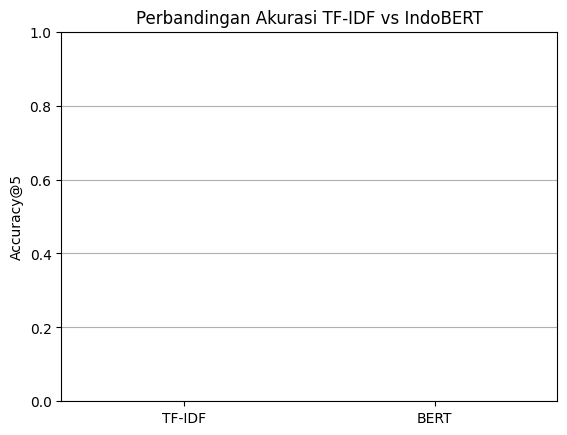

In [ ]:
import matplotlib.pyplot as plt

methods = ['TF-IDF', 'BERT']
accuracies = [acc_tfidf, acc_bert]

plt.bar(methods, accuracies, color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Accuracy@5")
plt.title("Perbandingan Akurasi TF-IDF vs IndoBERT")
plt.grid(axis='y')
plt.show()
